In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

2024-01-20 13:24:45.516173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pickle

In [3]:
# load the saved splitted data
train_pairs = pickle.load(open("data/train_pairs.pkl", "rb"))
val_pairs = pickle.load(open("data/val_pairs.pkl", "rb"))
test_pairs = pickle.load(open("data/test_pairs.pkl", "rb"))

In [4]:
# load vectorization for output language
from_disk = pickle.load(open("model/target_vectorization8.pkl", "rb"))
target_vectorization = layers.TextVectorization.from_config(from_disk['config'])

target_vectorization.set_weights(from_disk['weights'])


print(f"output vocabulary:\n{target_vectorization.get_vocabulary()}")

output vocabulary:
['', '[UNK]', 'd', 'a', 'c', 'b', 'f', 'g', 'e', 'h', 'j', 'i', '[start]', '[end]', 'k', 'l', 'm', 'ed', 'ee', 'ef', 'eg', 'eh']


2024-01-20 13:24:48.553751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# load vectorization for input language
from_disk = pickle.load(open("model/source_vectorization8.pkl", "rb"))
source_vectorization = layers.TextVectorization.from_config(from_disk['config'])

source_vectorization.set_weights(from_disk['weights'])


print(f"input vocabulary:\n{source_vectorization.get_vocabulary()}")

input vocabulary:
['', '[UNK]', 'a', 'd', 'c', 'b', 'f', 'g', 'e', 'h']


In [7]:
# dimensions based on the dataset analysis
input_vocab_size = 8 + 2  # +2 for "" and Unkown

# max text length in both input and output text is 47
# but I increased to 55 to account for longer texts that may exist in unseen data
output_seq_len = 55
input_seq_len = output_seq_len
output_vocab_size = 18 + 2 + 2  # +2 for "" and Unkown and +2 for [start] and [end]

# Data Preprocessing

In [8]:
batch_size = 128

In [9]:
def format_dataset(source, target):
    source = source_vectorization(source)
    target = target_vectorization(target)
    return (
    {
        "source": source,
        "translated": target[:, :-1]
        
    }, target[:, 1:])

def make_dataset(source_target_pairs, **kwargs):
    batch_size = kwargs.get("batch_size", 64)
    source_texts, target_texts = zip(*source_target_pairs)
    source_texts = list(source_texts)
    target_texts = list(target_texts)
    # source and target data will be stored in tf dataset
    dataset = tf.data.Dataset.from_tensor_slices((source_texts, target_texts))
    dataset = dataset.batch(batch_size)
    # apply data preprocessing function as in the order they stored in tf dataset
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

In [10]:
train_ds = make_dataset(train_pairs, batch_size=batch_size)
val_ds = make_dataset(val_pairs, batch_size=batch_size)

In [11]:
# debugging purpose
for inputs, targets in train_ds.take(1):
    print(f"inputs source shape: {inputs['source'].shape}")
    print(f"inputs translated shape: {inputs['translated'].shape}")
    print(f"target shape: {targets.shape}")

inputs source shape: (128, 55)
inputs translated shape: (128, 55)
target shape: (128, 55)


2024-01-20 09:57:48.108336: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [12]:
in_vocab = source_vectorization.get_vocabulary()
out_vocab = target_vectorization.get_vocabulary()
print(f"input vocabulary:\n{in_vocab}")
print(f"output vocabulary:\n{out_vocab}")

input vocabulary:
['', '[UNK]', 'a', 'd', 'c', 'b', 'f', 'g', 'e', 'h']
output vocabulary:
['', '[UNK]', 'd', 'a', 'c', 'b', 'f', 'g', 'e', 'h', 'j', 'i', '[start]', '[end]', 'k', 'l', 'm', 'ed', 'ee', 'ef', 'eg', 'eh']


# Model Selection

In [21]:
# dimension for Transformer
embed_dim = 16
latent_dim = 256

In [26]:
# encoder architecture
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="source")  # source language input
# embedding layer
x = layers.Embedding(input_dim=input_seq_len, output_dim=embed_dim, mask_zero=True)(encoder_inputs)
# bidirectional RNN layer
encoder_outputs = layers.Bidirectional(layers.GRU(latent_dim), merge_mode="sum")(x)

# decoder architecture
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="translated")  # target language input
# embedding layer
x = layers.Embedding(input_dim=output_seq_len, output_dim=embed_dim, mask_zero=True)(decoder_inputs)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoder_outputs)
x = layers.Dropout(0.5)(x)
#output = layers.Dense(output_vocab_size, activation="softmax")(x)
output = layers.Dense(output_vocab_size)(x)


model = keras.Model([encoder_inputs, decoder_inputs], output)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 translated (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, None, 16)     880         ['source[0][0]']                 
                                                                                                  
 embedding_7 (Embedding)        (None, None, 16)     880         ['translated[0][0]']             
                                                                                            

In [8]:
def masked_loss(label, pred):
    # loss fucntion for machine translation(Cross entropy modified to account for masking)
    mask = label != 0
    loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_function(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask  # no loss computed for a token that is masked in a sequence
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)  # averaged by the number of non-mask tokens
    return loss
    

def masked_accuracy(label, pred):
    # model accuracy computation accounting for masking
    pred = tf.argmax(pred, axis=-1)
    label = tf.cast(label, pred.dtype)
    accurate = label == pred  # boolean tensor True if predicted correctly
    mask = label != 0
    accurate = accurate & mask  # mark as accurate if correctly predicted and not masked token
    accurate = tf.cast(accurate, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accurate) / tf.reduce_sum(mask)  # averaged by the number of non-mask tokens

In [28]:
# training set up and model training
lr = 0.001
weight_decay = 0.01
optim = tf.keras.optimizers.RMSprop(learning_rate=lr)
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="model/rnn_translator.keras", monitor='val_loss',
                                    saves_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=9, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-7, verbose=1),
]
model.compile(
    optimizer=optim,
    #loss="sparse_categorical_crossentropy",
    loss=masked_loss,
    metrics=[masked_accuracy],
)
history = model.fit(train_ds,
                          epochs=30,
                          validation_data=val_ds,
                          callbacks=callbacks)

Epoch 1/30
613/613 [==============================] - 167s 264ms/step - loss: 0.8167 - masked_accuracy: 0.4884 - val_loss: 0.4772 - val_masked_accuracy: 0.6792 - lr: 0.0010
Epoch 2/30
613/613 [==============================] - 160s 260ms/step - loss: 0.4386 - masked_accuracy: 0.6983 - val_loss: 0.3439 - val_masked_accuracy: 0.7600 - lr: 0.0010
Epoch 3/30
613/613 [==============================] - 160s 261ms/step - loss: 0.3260 - masked_accuracy: 0.7727 - val_loss: 0.2754 - val_masked_accuracy: 0.8027 - lr: 0.0010
Epoch 4/30
613/613 [==============================] - 160s 261ms/step - loss: 0.2570 - masked_accuracy: 0.8179 - val_loss: 0.2088 - val_masked_accuracy: 0.8487 - lr: 0.0010
Epoch 5/30
613/613 [==============================] - 160s 260ms/step - loss: 0.2082 - masked_accuracy: 0.8493 - val_loss: 0.1695 - val_masked_accuracy: 0.8732 - lr: 0.0010
Epoch 6/30
613/613 [==============================] - 160s 261ms/step - loss: 0.1735 - masked_accuracy: 0.8727 - val_loss: 0.1655 - val

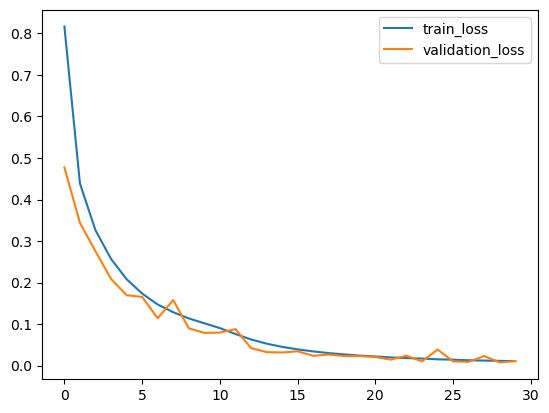

In [29]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(len(train_loss))
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs, val_loss, label="validation_loss")
plt.legend()
plt.show()

In [9]:
test_input_txt = [pair[0] for pair in test_pairs]
test_target_txt = [pair[1] for pair in test_pairs]

In [10]:
# load model
model = keras.models.load_model("model/rnn_translator.keras",
                               custom_objects={
                                         "masked_loss": masked_loss,
                                         "masked_accuracy": masked_accuracy,
                                     })

In [11]:
# add softmax activation in the output of the model
inputs = model.inputs
out = model.outputs[0]
outputs = layers.Activation("softmax")(out)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 translated (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, None, 16)     880         ['source[0][0]']                 
                                                                                                  
 embedding_7 (Embedding)        (None, None, 16)     880         ['translated[0][0]']             
                                                                                              

In [12]:
# translated text generation function
class TokenGenerator():
    def __init__(self):
        raise NotImplemented
    
    def __call__(self):
        raise NotImplemented

class Generate_tokens(TokenGenerator):
    def __init__(self):
        return
    
    def __call__(self, input_seq, target_vectorization, source_vectorization, model, **kwargs):
        max_out_seq_len = kwargs.get("max_out_seq_len", 30)
        
        out_vocab = target_vectorization.get_vocabulary()
        out_index_lookup = dict(zip(range(len(out_vocab)), out_vocab))  # mapping vectorization to vocab
        tokenized_input_seq = source_vectorization([input_seq])
        decoded_sentence = "[start]"
        for i in range(max_out_seq_len):
            tokenized_out_sentence = target_vectorization([decoded_sentence])[:, :-1]
            # input: 1st elem for encoder, and 2nd elem for the first self-attention layer in decoder
            predictions = model([tokenized_input_seq, tokenized_out_sentence])
            predicted_token_index = np.argmax(predictions[0, i, :])  # a token with highest probabillity
            predicted_token = out_index_lookup[predicted_token_index]
            decoded_sentence += " " + predicted_token
            if predicted_token == "[end]":
                break
        return decoded_sentence

In [13]:
# translate the source language to target language using our best model
token_gen = Generate_tokens()
translated_texts = []
print(f"Total Number of Input Text Sequences: {len(test_input_txt)}")
correct_count = 0
rand_idx = np.random.randint(0, high=len(test_input_txt)-1, size=100)
for i in range(len(test_input_txt)):
    if i % 100 == 0: print(f"Currently at sequence {i}, and count: {correct_count}")
    translated_seq = token_gen(test_input_txt[i], target_vectorization,
                    source_vectorization, model=model, max_out_seq_len=output_seq_len)
    if i in rand_idx:
        print(f"Model Tranlsated: {translated_seq}")
        print(f"Ground-Truth:     {test_target_txt[i]}")
    if translated_seq == test_target_txt[i]:
        correct_count += 1
    translated_texts.append(translated_seq)

Total Number of Input Text Sequences: 16800
Currently at sequence 0, and count: 0
Model Tranlsated: [start] b d b d a d d e c e b d b d a h g h i b d a e k b d a h j l m a g f ed a e ee c e a d ef eg [end]
Ground-Truth:     [start] b d b d a d d e c e b d b d a h g h i b d a e k b d a h j l m a g f ed a e ee c e a d ef eg [end]
Currently at sequence 100, and count: 86
Currently at sequence 200, and count: 171
Currently at sequence 300, and count: 260
Model Tranlsated: [start] c e b d b d b d b d c d b d a f i j a h g h k a h e f l a d d m b d c f a e ef a h ed ee eg [end]
Ground-Truth:     [start] c e b d b d b d b d c d b d a d i j a h g h k a h e f l a d d m b d c f a e ef a h ed ee eg [end]
Currently at sequence 400, and count: 342
Model Tranlsated: [start] c g c f b d b d a f f g a g e h a e i b d a f j k a d d l [end]
Ground-Truth:     [start] c g c f b d b d a f f g a g e h a e i b d a f j k a d d l [end]
Currently at sequence 500, and count: 433
Model Tranlsated: [start] c d c f

Currently at sequence 5600, and count: 4777
Model Tranlsated: [start] c d c e c e a d e f b d c f a d h i a e j a g g k a d d l c d c f a h m ed ee [end]
Ground-Truth:     [start] c d c e c e a d e f b d c f a d h i a e j a g g k a d d l c d c d a h m ed ee [end]
Currently at sequence 5700, and count: 4865
Currently at sequence 5800, and count: 4955
Currently at sequence 5900, and count: 5041
Model Tranlsated: [start] b d c e c e c e a f f g c f a d h i a h d e j [end]
Ground-Truth:     [start] b d c e c e c e a f f g c f a d h i a h d e j [end]
Currently at sequence 6000, and count: 5123
Currently at sequence 6100, and count: 5210
Model Tranlsated: [start] c d b d c d a e f c d a g g h a h d e i c f a g j k [end]
Ground-Truth:     [start] c d b d c d a e f c d a g g h a h d e i c f a g j k [end]
Currently at sequence 6200, and count: 5293
Currently at sequence 6300, and count: 5377
Currently at sequence 6400, and count: 5459
Currently at sequence 6500, and count: 5543
Model Tranlsated

Model Tranlsated: [start] c f b d c d a f e f a d d g b d c d b d a e k a f j l a h h i m b d a g ed ee [end]
Ground-Truth:     [start] c f b d c d a f e f a d d g b d c d b d a e k a f j l a h h i m b d a g ed ee [end]
Currently at sequence 10500, and count: 8980
Model Tranlsated: [start] b d c g a f d e b d b d c d c e a g i j a d h k a g g l a e m a f f ed [end]
Ground-Truth:     [start] b d c g a f d e b d b d c d c e a g i j a d h k a g g l a e m a f f ed [end]
Model Tranlsated: [start] c e b d a d d e c e a d f g a e h b d c e a h i j k [end]
Ground-Truth:     [start] c e b d a d d e c e a d f g a e h b d c e a h i j k [end]
Model Tranlsated: [start] c g c d c d a e f c d a h e g h b d a g i j a f d k [end]
Ground-Truth:     [start] c g c d c d a e f c d a h e g h b d a g i j a f d k [end]
Model Tranlsated: [start] b d b d c g a h d e f a e g b d a e i b d c d a g k l a d j m a f h ed [end]
Ground-Truth:     [start] b d b d c g a h d e f a e g b d a e i b d c d a g k l a d j m a 

Model Tranlsated: [start] b d a e d c e c g a h e f g b d a e i b d a e k a g j l a d h m b d a d ed ee [end]
Ground-Truth:     [start] b d a e d c e c g a h e f g b d a e i b d a e k a g j l a d h m b d a d ed ee [end]
Model Tranlsated: [start] c d c e a g d e a e f b d a f g h c e b d b d a d k l b d a h j m ed a g i ee [end]
Ground-Truth:     [start] c d c e a g d e a e f b d a f g h c e b d b d a d k l b d a h j m ed a g i ee [end]
Model Tranlsated: [start] b d a e d b d b d b d a d g h b d c e a g j k a d i l c e a h f m ed a f e ee [end]
Ground-Truth:     [start] b d a e d b d b d b d a d g h b d c e a g j k a d i l c e a h f m ed a f e ee [end]
Currently at sequence 14700, and count: 12598
Currently at sequence 14800, and count: 12682
Currently at sequence 14900, and count: 12769
Currently at sequence 15000, and count: 12860
Currently at sequence 15100, and count: 12948
Currently at sequence 15200, and count: 13034
Currently at sequence 15300, and count: 13120
Currently at seque

In [14]:
print(f"Model Accuracy: {correct_count / len(translated_texts)}")

Model Accuracy: 0.8576190476190476
